This code transfers the raster Mining data to tabular form and calculate if each Prio Grid Area has the mining or not.

Data source: 
1. Prio Grid Data: a standardized spatial grid structure with global coverage at a resolution of 0.5 x 0.5 decimal degrees, 55.5km x 55.5km, 
https://grid.prio.org/#/download

2. GeoTiff Data: a 30 arc-minute resolution(approximately 55x55 km at the equator) data
reference: https://doi.pangaea.de/10.1594/PANGAEA.910894

In [ ]:
import rasterio
import pandas as pd
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd

pd.reset_option('display.float_format')
np.set_printoptions(suppress=True)

### 1 Read Data
##### 1.1 Read Prio Grid Data

In [4]:
prio_grid=gpd.read_file('priogrid_cellshp\priogrid_cell.shp')
print(prio_grid.shape)

# xcoord, ycoord: the position of lower right corner in the grid cell
prio_grid.head()

(259200, 6)


,gid,xcoord,ycoord,col,row,geometry
0,259168,163.75,89.75,688,360,"POLYGON ((163.50000 89.50000, 163.50000 90.000..."
1,259169,164.25,89.75,689,360,"POLYGON ((164.00000 89.50000, 164.00000 90.000..."
2,259170,164.75,89.75,690,360,"POLYGON ((164.50000 89.50000, 164.50000 90.000..."
3,259171,165.25,89.75,691,360,"POLYGON ((165.00000 89.50000, 165.00000 90.000..."
4,259172,165.75,89.75,692,360,"POLYGON ((165.50000 89.50000, 165.50000 90.000..."


##### 1.2 Read GeoTiff Data

In [5]:

dataset=rasterio.open('Global_mining\global_miningarea_v1_30arcminute.tif')
dataset

<open DatasetReader name='Global_mining\global_miningarea_v1_30arcminute.tif' mode='r'>

In [6]:
# common info of GeoTiff
print(dataset.crs)
print(dataset.bounds)
print(dataset.indexes)
print(dataset.transform)
print(dataset.count)

EPSG:4326
BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
(1,)
| 0.50, 0.00,-180.00|
| 0.00,-0.50, 90.00|
| 0.00, 0.00, 1.00|
1


### 2 Process GeoTiff Data

In [7]:
band_1=dataset.read(1)
band_1


array([[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       ...,
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00]],
      dtype=float32)

In [8]:
np.unique(band_1).size
np.sort(np.unique(band_1))

array([-3.4000000e+38,  0.0000000e+00,  5.7859165e-03, ...,
        5.2166199e+02,  5.5259027e+02,  7.4645746e+02], dtype=float32)

In [9]:
# if value <=0, represent geographic info
# if value >0, represent mining area
tmp=band_1<= 0 
tmp_2=tmp.astype(int)
tmp_2

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

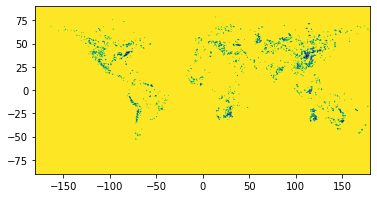

<AxesSubplot:>

In [10]:
# visualization the raw data
show(tmp_2,transform=dataset.transform)

In [11]:
# find the index of loc where is mining area
xs, ys = np.where(tmp_2 == 0)
print((xs,ys))

(array([ 23,  29,  33, ..., 283, 285, 285], dtype=int64), array([388, 166, 190, ..., 215, 216, 217], dtype=int64))


In [12]:
x_cor=[]
y_cor=[]
for x, y in zip(xs,ys):  
    x_cor.append(dataset.xy(x, y)[0])
    y_cor.append(dataset.xy(x, y)[1])

d={'x_cor':x_cor,'y_cor':y_cor,'mining_area':1}   
df=pd.DataFrame(data=d)
print(df.shape)
df.head()

(3331, 3)


,x_cor,y_cor,mining_area
0,14.25,78.25,1
1,-96.75,75.25,1
2,-84.75,73.25,1
3,-84.25,73.25,1
4,113.75,71.25,1


### 3 Create new variable mining area and calculate the mining bool value for each grid cell


In [13]:
prio_mining=prio_grid.merge(right=df, how='left',
                    left_on=['xcoord','ycoord'],
                    right_on=['x_cor','y_cor'])
print(prio_mining.shape)
prio_mining.head()

(259200, 9)


,gid,xcoord,ycoord,col,row,geometry,x_cor,y_cor,mining_area
0,259168,163.75,89.75,688,360,"POLYGON ((163.50000 89.50000, 163.50000 90.000...",NaN,NaN,NaN
1,259169,164.25,89.75,689,360,"POLYGON ((164.00000 89.50000, 164.00000 90.000...",NaN,NaN,NaN
2,259170,164.75,89.75,690,360,"POLYGON ((164.50000 89.50000, 164.50000 90.000...",NaN,NaN,NaN
3,259171,165.25,89.75,691,360,"POLYGON ((165.00000 89.50000, 165.00000 90.000...",NaN,NaN,NaN
4,259172,165.75,89.75,692,360,"POLYGON ((165.50000 89.50000, 165.50000 90.000...",NaN,NaN,NaN


In [14]:
# if mining_area = 0, this area doesn't have mining polygon
# if mining area = 1, it has mining polygon
mining_df=prio_mining.drop(columns=['col','row','x_cor','y_cor'])
mining_df.replace(np.nan,0,inplace=True)
print(mining_df.shape)
mining_df.to_csv('mining_df.csv')
mining_df.head()

(259200, 5)


,gid,xcoord,ycoord,geometry,mining_area
0,259168,163.75,89.75,"POLYGON ((163.50000 89.50000, 163.50000 90.000...",0.0
1,259169,164.25,89.75,"POLYGON ((164.00000 89.50000, 164.00000 90.000...",0.0
2,259170,164.75,89.75,"POLYGON ((164.50000 89.50000, 164.50000 90.000...",0.0
3,259171,165.25,89.75,"POLYGON ((165.00000 89.50000, 165.00000 90.000...",0.0
4,259172,165.75,89.75,"POLYGON ((165.50000 89.50000, 165.50000 90.000...",0.0


### 4 Validation

<AxesSubplot:>

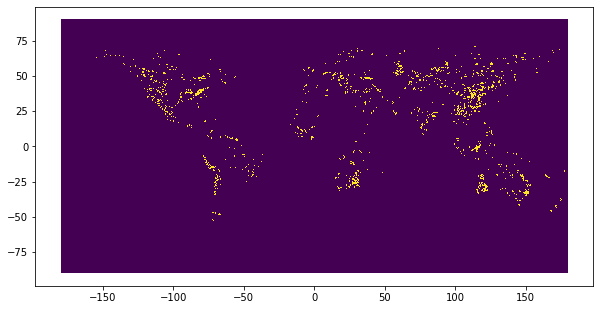

In [15]:
# visualize the final result data
mining_gpd = gpd.GeoDataFrame(mining_df, geometry='geometry', crs="EPSG:4326")
fig, ax = plt.subplots(figsize=(10,10))
mining_df.plot(ax=ax, column='mining_area')